### Demo for reading peaks and high-water marks and comparing with model output

Fields in the .csv files are described here: https://my.usgs.gov/confluence/display/WSN/STN+Data+Dictionary+-+Top+Level
(but this will stop working on Jan 27, 2023, and a Sharepoint site will replace it)

This notebook demonstrates reading the `.csv` files, picking out useful data, saveing those as smaller `.csv` files, plotting the data, and finding the data closest to a target lat/lon.

csherwood@usgs.gov

In [13]:
import pandas as pd
import numpy as np

import xroms
import matplotlib.pyplot as plt
from scipy import stats

# These files were downloaded from https://stn.wim.usgs.gov/fev/#2022Ian on 1/17/2023
hwm_file = r'/vortexfs1/home/csherwood/proj/NOPP/data/FilteredHWMs.csv'
peaks_file = r'/vortexfs1/home/csherwood/proj/NOPP/data/FilteredPeaks.csv'
inst_file = r'/vortexfs1/home/csherwood/proj/NOPP/data/FilteredInstrument.csv'

### Load the peaks data.
Examination reveals:  
* No time or stage estimates were made
* vdatum = NAVD88 except for one point, which we drop
* height_above_gnd is all NaNs
* all times are UTC

In [2]:
df = pd.read_csv(peaks_file)
#drop the record with local coordinates
df = df.drop(labels=3, axis=0)
# make a copy of the dataframe with the stuff we want in it.
df_peaks = df[['latitude_dd','longitude_dd','peak_date']].copy()
df_peaks['peak_stage_m'] = df['peak_stage'].values*0.3048
df_peaks.describe()

,latitude_dd,longitude_dd,peak_stage_m
count,56.000000,56.000000,56.000000
mean,28.645425,-80.896103,1.812798
std,3.600170,1.829941,0.931228
min,24.546980,-82.274410,0.213360
25%,26.343383,-81.812393,1.116330
50%,27.580440,-81.415569,1.836420
75%,29.786145,-80.954840,2.257806
max,38.790987,-75.140150,4.032504


### Read the high-water mark file
Examination reveals:  
    * All vdatum are NAVD88

Values for `hwm_type_id`
```
HWM type code.  Current possibilities:
1 Mud
2 Debris
3 Clear water
4 Vegetation line
5 Seed line
6 Stain line
7 Melted snow line
8 Present at peak (direct observation)
9 Other (Note in Description box)
```
Values for `hwm_quality_id`
```
HWM quality code.  Current possibilities:
1 Excellent: +/- 0.05 ft
2 Good: +/- 0.10 ft
3 Fair: +/- 0.20 ft
4 Poor: +/- 0.40 ft
5 VP: > 0.40 ft
6 Unknown/Historical
```
`stillwater` is boolean
    


In [3]:
df1 = pd.read_csv(hwm_file)
df1

,latitude,longitude,eventName,hwmTypeName,hwmQualityName,verticalDatumName,verticalMethodName,approvalMember,markerName,horizontalMethodName,...,event,peak_summary,survey_member,marker,approval,files,site,vertical_datums,flag_member,Links
0,27.265787,-82.551233,2022 Ian,Debris,Poor: +/- 0.40 ft,NAVD88,Level Gun,NaN,NaN,Map (digital or paper),...,NaN,NaN,NaN,NaN,NaN,System.Collections.Generic.HashSet`1[STNDB.file],NaN,NaN,NaN,NaN
1,27.113984,-82.465796,2022 Ian,Debris,Poor: +/- 0.40 ft,NAVD88,Level Gun,Kevin Grimsley,Not marked,Map (digital or paper),...,NaN,NaN,NaN,NaN,NaN,System.Collections.Generic.HashSet`1[STNDB.file],NaN,NaN,NaN,NaN
2,29.286538,-81.054583,2022 Ian,Debris,Good: +/- 0.10 ft,NAVD88,Level Gun,Patrick Ryan,NaN,Map (digital or paper),...,NaN,NaN,NaN,NaN,NaN,System.Collections.Generic.HashSet`1[STNDB.file],NaN,NaN,NaN,NaN
3,29.286667,-81.054639,2022 Ian,Seed line,Excellent: +/- 0.05 ft,NAVD88,Level Gun,Patrick Ryan,NaN,Map (digital or paper),...,NaN,NaN,NaN,NaN,NaN,System.Collections.Generic.HashSet`1[STNDB.file],NaN,NaN,NaN,NaN
4,28.623731,-80.795234,2022 Ian,Seed line,Fair: +/- 0.20 ft,NAVD88,Level Gun,Kevin Grimsley,NaN,Phone/Car GPS,...,NaN,NaN,NaN,NaN,NaN,System.Collections.Generic.HashSet`1[STNDB.file],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,28.545330,-81.371224,2022 Ian,Seed line,Fair: +/- 0.20 ft,NAVD88,RT-GNSS,John Storm,Marker,Phone/Car GPS,...,NaN,NaN,NaN,NaN,NaN,System.Collections.Generic.HashSet`1[STNDB.file],NaN,NaN,NaN,NaN
360,28.534942,-81.336802,2022 Ian,Debris,Poor: +/- 0.40 ft,NAVD88,RT-GNSS,John Storm,NaN,Phone/Car GPS,...,NaN,NaN,NaN,NaN,NaN,System.Collections.Generic.HashSet`1[STNDB.file],NaN,NaN,NaN,NaN
361,28.534942,-81.336802,2022 Ian,Debris,Poor: +/- 0.40 ft,NAVD88,RT-GNSS,John Storm,NaN,Phone/Car GPS,...,NaN,NaN,NaN,NaN,NaN,System.Collections.Generic.HashSet`1[STNDB.file],NaN,NaN,NaN,NaN
362,26.667526,-81.879386,2022 Ian,Seed line,Good: +/- 0.10 ft,NAVD88,RT-GNSS,Missing Approval,NaN,Phone/Car GPS,...,NaN,NaN,NaN,NaN,NaN,System.Collections.Generic.HashSet`1[STNDB.file],NaN,NaN,NaN,NaN


### Pull a subset of data from the dataframe. 
All of the data for H. Ian are in NAVD88, so not testing for that.

In [4]:
# Pull data we want into a dataset, rename as 'df_hwm'
df_hwm = df1[['latitude_dd','longitude_dd','hwm_type_id','hwm_quality_id','stillwater']].copy()

# add some columns with data converted to meters
df_hwm['elev_m'] = df1['elev_ft'].values * 0.3048
df_hwm['uncertainty_m'] = df1['uncertainty'].values * 0.3048
df_hwm['height_above_gnd_m'] = df1['height_above_gnd'].values * 0.3048

# you could save this as a .csv file using:
df_hwm.to_csv('hwm_data.csv', index=False, float_format = '%.6f')

# get the statistics for each column
# note: not all of the columns have data...some are missing uncertainty and/or height_above_ground
df_hwm.describe()

,latitude_dd,longitude_dd,hwm_type_id,hwm_quality_id,stillwater,elev_m,uncertainty_m,height_above_gnd_m
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,296.000000,343.000000
mean,27.111323,-81.735916,4.587912,1.967033,0.131868,4.541453,0.039560,0.935478
std,1.583946,0.728046,1.108677,0.958656,0.338813,6.115265,0.133485,0.772790
min,24.546980,-82.551233,1.000000,1.000000,0.000000,0.228600,0.000305,0.000000
25%,26.438324,-82.023910,5.000000,1.000000,0.000000,2.103120,0.015240,0.289560
50%,26.546202,-81.859483,5.000000,2.000000,0.000000,2.636520,0.025603,0.758952
75%,26.716158,-81.731027,5.000000,2.000000,0.000000,3.535680,0.052426,1.450848
max,38.790490,-75.140640,9.000000,5.000000,1.000000,30.845760,2.286000,3.797808


<AxesSubplot: xlabel='longitude_dd', ylabel='latitude_dd'>

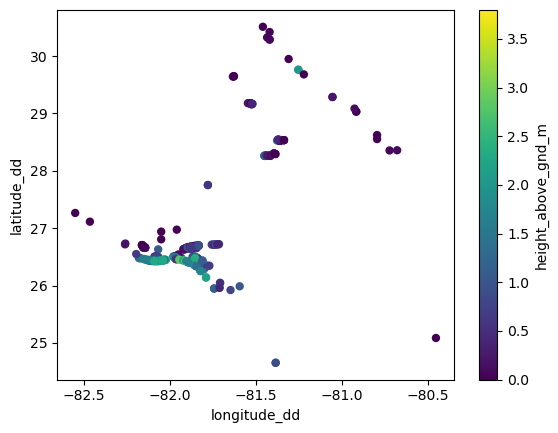

In [5]:
# For fun, make a map of the height above ground of the high-water marks
df_hwm.plot.scatter(x='longitude_dd', y='latitude_dd', s = 25, c = 'height_above_gnd_m' )

#### Demonstrate finding result closest to a target lat/long (not actually needed)

In [15]:
# Calc. distances from target with Haversine formula
# Modified after https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

# Provide target lat/lon...the formula requires radians
tlat = np.deg2rad( 27.8 )
tlon = np.deg2rad( -81.7 )
df_hwm[["lat_rad", "lon_rad"]] = np.deg2rad(df_hwm[['latitude_dd', 'longitude_dd']])
dlon = df_hwm['lon_rad'].values - tlon
dlat = df_hwm['lat_rad'].values - tlat

a = np.sin(dlat/2.0)**2 + np.cos(tlat) * np.cos(df_hwm['lat_rad'].values) * np.sin(dlon/2.0)**2
# multiply by radius of earth to get result in km
dist = 6367.* 2. * np.arcsin(np.sqrt(a))

# index of closest one
imin = np.argmin( dist )

print(dist[imin])

print(df_hwm.iloc[imin])

9.423338377104734
latitude_dd           27.752537
longitude_dd         -81.779424
hwm_type_id            5.000000
hwm_quality_id         2.000000
stillwater             1.000000
elev_m                24.414480
uncertainty_m          0.167640
height_above_gnd_m     0.335280
lat_rad                0.484373
lon_rad               -1.427320
Name: 340, dtype: float64


#### Load the model output

In [16]:
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Ian2022/ian5/qck/ian_ocean_sanibel_qck.nc'
ds=xroms.open_netcdf(url)

# define bounding box (This is too big)
lonmin = -82.7
lonmax = -80.3
latmin = 24.
latmax = 31.

# this condition defines the region of interest
box = ((lonmin < ds.lon_rho) & (ds.lon_rho < lonmax) & (latmin < ds.lat_rho) & (ds.lat_rho < latmax)).compute()

In [39]:
ds

<xarray.Dataset>
Dimensions:          (tracer: 2, boundary: 4, s_rho: 12, s_w: 13, eta_rho: 900,
                      xi_rho: 600, xi_u: 599, eta_v: 899, ocean_time: 145)
Coordinates: (12/31)
  * s_rho            (s_rho) float64 -0.9583 -0.875 -0.7917 ... -0.125 -0.04167
  * s_w              (s_w) float64 -1.0 -0.9167 -0.8333 ... -0.1667 -0.08333 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(900, 600), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(900, 600), meta=np.ndarray>
    lon_u            (eta_rho, xi_u) float64 dask.array<chunksize=(900, 599), meta=np.ndarray>
    lat_u            (eta_rho, xi_u) float64 dask.array<chunksize=(900, 599), meta=np.ndarray>
    ...               ...
    z_rho_v0         (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(12, 899, 600), meta=np.ndarray>
    z_rho_psi0       (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(12, 899, 599), meta=np.ndarray>
    z_w0             (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(13, 900, 600), meta=np.ndarray>
    z_w_u0           (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(13, 900, 599), meta=np.ndarray>
    z_w_v0           (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(13, 899, 600), meta=np.ndarray>
    z_w_psi0         (s_w, eta_v, xi_u) float64 dask.array<chunksize=(13, 899, 599), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary
Data variables: (12/152)
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    dstart           datetime64[ns] ...
    shuffle          int32 ...
    ...               ...
    dV_u             (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 12, 900, 599), meta=np.ndarray>
    dV_w_u           (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 13, 900, 599), meta=np.ndarray>
    dV_v             (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 12, 899, 600), meta=np.ndarray>
    dV_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 13, 899, 600), meta=np.ndarray>
    dV_psi           (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 12, 899, 599), meta=np.ndarray>
    dV_w_psi         (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 13, 899, 599), meta=np.ndarray>
Attributes: (12/32)
    file:                            ian_ocean_sanibel_qck.nc
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS quicksave file
    title:                           USEAST2_NOPP
    var_info:                        ROMS/External/varinfo.dat
    ...                              ...
    tiling:                          012x007
    history:                         ROMS/TOMS, Version 3.9, Wednesday - Febr...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     USEAST2_NOPP, ANA_BSFLUX, ANA_BTFLUX, AN...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               12

In [17]:
dss=ds.where(box, drop=True).zeta
dss

<xarray.DataArray 'zeta' (ocean_time: 145, eta_rho: 900, xi_rho: 600)>
dask.array<where, shape=(145, 900, 600), dtype=float32, chunksize=(1, 900, 600), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 -82.17 -82.16 -82.15 ... -81.9 -81.9
    lat_rho     (eta_rho, xi_rho) float64 26.2 26.2 26.21 ... 27.21 27.22 27.22
  * ocean_time  (ocean_time) datetime64[ns] 2022-09-26 ... 2022-10-02
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 593 594 595 596 597 598 599
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 893 894 895 896 897 898 899
Attributes:
    long_name:    free-surface
    units:        meter
    time:         ocean_time
    grid:         <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cen...
    location:     face
    field:        free-surface, scalar, series
    _ChunkSizes:  [  1 900 600]

In [41]:
# Get wet/dry mask (1=wet, 0=dry) and calculate max (should correspond with max water levels)
dswd = ds.where(box, drop=True).wetdry_mask_rho
wd = dswd.max(dim='ocean_time').compute()

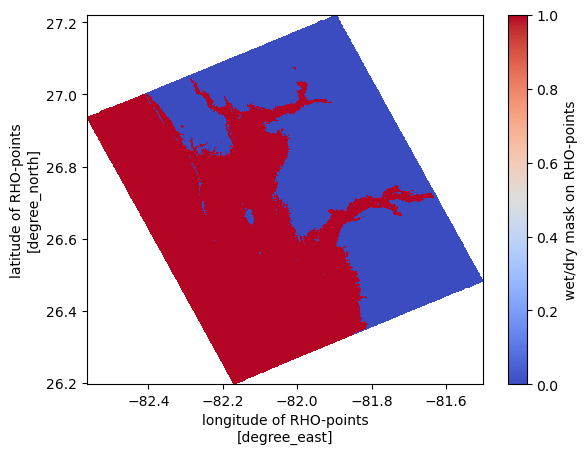

In [42]:
wd.plot(x="lon_rho", y="lat_rho", cmap='coolwarm')

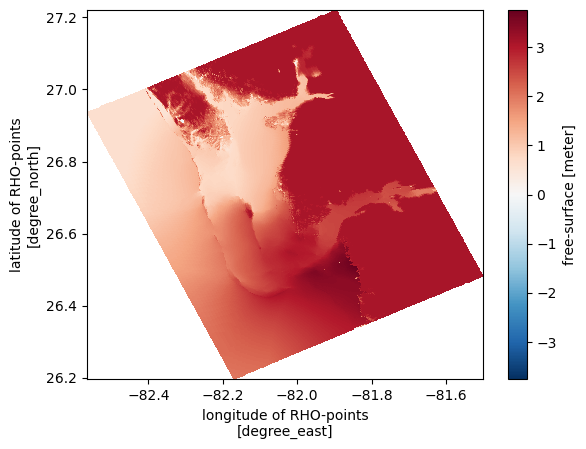

In [18]:
# find the maximum water level over the entire time
# adding the .compute() function was key to speeding up the lat/lon lookup below
zmax = dss.max(dim='ocean_time').compute()

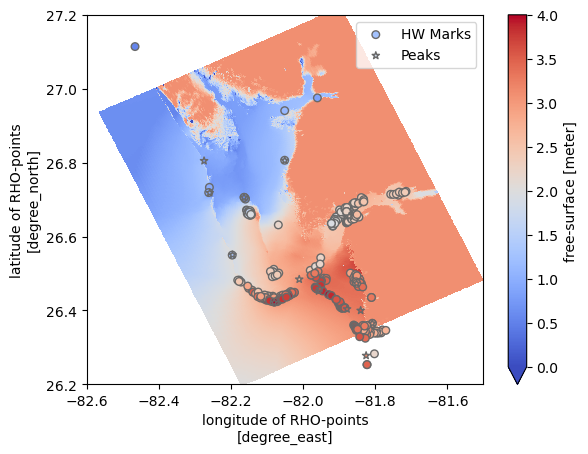

In [69]:
# TODO - make real maps
vmin=0
vmax=4
fig = plt.figure()
zmax.plot(x="lon_rho", y="lat_rho", vmin=vmin, vmax=vmax, cmap='coolwarm')
# Make a map of the height above ground of the high-water marks
plt.scatter( df_hwm['longitude_dd'], df_hwm['latitude_dd'], s=30, c = df_hwm['elev_m'], \
            edgecolor='dimgray',vmin=vmin, vmax=vmax, label='HW Marks',cmap='coolwarm' )
plt.scatter( df_peaks['longitude_dd'], df_peaks['latitude_dd'], s=30, c = df_peaks['peak_stage_m'], \
            edgecolor='dimgray', vmin=vmin, vmax=vmax, marker = '*', label='Peaks',cmap='coolwarm' )
plt.xlim([-82.6,-81.5])
plt.ylim([26.2,27.2])
plt.legend()

In [50]:
# Loop through the high-water marks and find zmax in nearest model grid point
# This was glacially slow before I added the .compute() function while calculating zmax
meas_hwm = df_hwm['elev_m'].values
meas_qc = df_hwm['hwm_quality_id'].values
model_zeta_hwm = np.nan*np.ones_like( meas_hwm )
hwm_mask = np.nan*np.ones_like( meas_hwm )

for i, (lonr, latr) in enumerate( zip(df_hwm['longitude_dd'].values, df_hwm['latitude_dd'].values) ):
    model_zeta_hwm[i] =  zmax.xroms.sel2d(lonr, latr).values
    hwm_mask[i] = wd.xroms.sel2d(lonr, latr).values

meas_peaks = df_peaks['peak_stage_m'].values
model_zeta_peaks = np.nan*np.ones_like( meas_peaks )
peak_mask = np.nan*np.ones_like( meas_peaks )
for i, (lonr, latr) in enumerate( zip(df_peaks['longitude_dd'].values, df_peaks['latitude_dd'].values) ):
    model_zeta_peaks[i] =  zmax.xroms.sel2d(lonr, latr).values
    peak_mask[i] =  wd.xroms.sel2d(lonr, latr).values

In [101]:
mod_hwm_good = model_zeta_hwm[meas_qc<3][hwm_mask[meas_qc<3]==1]
meas_hwm_good = meas_hwm[meas_qc<3][hwm_mask[meas_qc<3]==1]
mod_hwm_other = model_zeta_hwm[meas_qc>=3][hwm_mask[meas_qc>=3]==1]
meas_hwm_other = meas_hwm[meas_qc>=3][hwm_mask[meas_qc>=3]==1]
model_peaks = model_zeta_peaks[peak_mask==1]
meas_mpeaks = meas_peaks[peak_mask==1]

gradient_hwm_good, intercept_hwm_good, r_value, p_value, std_err = stats.linregress(mod_hwm_good, meas_hwm_good)
ts_good = 'HWM, Good QC: $r^2$={:.2f}, slope={:.2f}'.format(r_value,gradient_hwm_good)
print(ts_good)
gradient_hwm_other, intercept_hwm_other, r_value, p_value, std_err = stats.linregress(mod_hwm_other, meas_hwm_other)
ts_other = 'HWM, Other QC: $r^2$={:.2f}, slope={:.2f}'.format(r_value,gradient_hwm_fair)
print(ts_other)
gradient_peaks, intercept_peaks, r_value, p_value, std_err = stats.linregress(model_peaks, meas_mpeaks)
ts_peaks = 'Peaks: $r^2$={:.2f}, slope={:.2f}'.format(r_value,gradient_peaks)
print(ts_peaks)
x_good = np.array((np.min(mod_hwm_good), np.max(mod_hwm_good)))
y_good = intercept_hwm_good + gradient_hwm_good * x_good
x_other = np.array((np.min(mod_hwm_other), np.max(mod_hwm_other)))
y_other = intercept_hwm_other + gradient_hwm_other * x_other
x_peaks = np.array((np.min(model_peaks), np.max(model_peaks)))
y_peaks = intercept_peaks + gradient_peaks * x_peaks

HWM, Good QC: $r^2$=0.82, slope=1.35
HWM, Other QC: $r^2$=0.80, slope=1.02
Peaks: $r^2$=0.85, slope=1.06


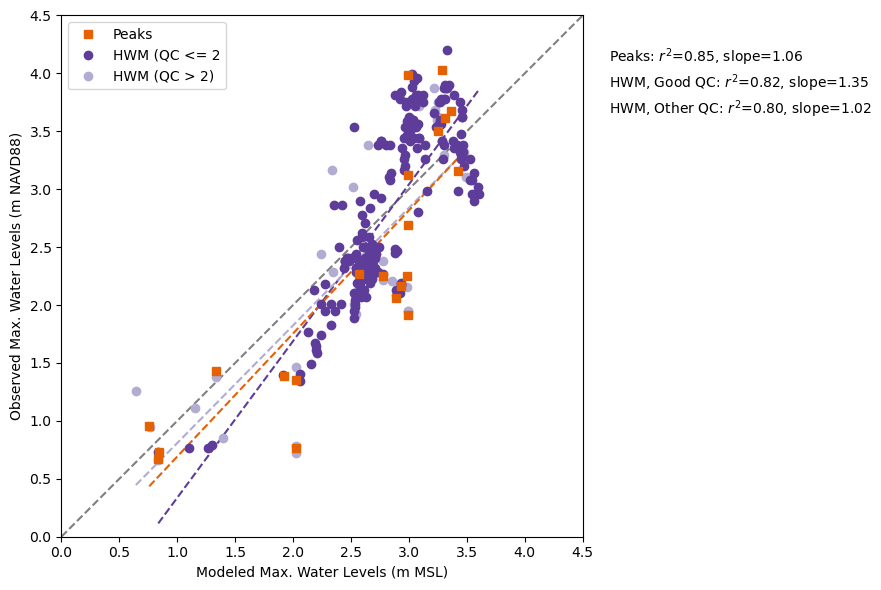

In [111]:
cols = ['#e66101','#fdb863','#b2abd2','#5e3c99']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # setup the plot
plt.plot([0,4.5],[0,4.5],'--',c='grey')
plt.plot( x_good, y_good, '--',c=cols[3])
plt.plot( x_other, y_other, '--',c=cols[2])
plt.plot( x_peaks, y_peaks, '--',c=cols[0])
plt.plot(mod_hwm_other, meas_hwm_other,'o',c=cols[2],label='HWM (QC > 2)')
plt.plot(mod_hwm_good, meas_hwm_good,'o',c=cols[3],label='HWM (QC <= 2')
plt.plot(model_zeta_peaks[peak_mask==1], meas_peaks[peak_mask==1],'s', c=cols[0], label='Peaks')

plt.ylabel('Observed Max. Water Levels (m NAVD88)')
plt.xlabel('Modeled Max. Water Levels (m MSL)')
plt.xlim([0,4.5])
plt.ylim([0,4.5])

# chagne the order of stuff in the legend
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [2,1,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

#plt.legend()
plt.text(x=1.05, y=.90, s=ts_peaks, fontsize=10, c='k',transform=ax.transAxes,\
             horizontalalignment='left', verticalalignment='bottom')
plt.text(x=1.05, y=.85, s=ts_good, fontsize=10, c='k',transform=ax.transAxes,\
             horizontalalignment='left', verticalalignment='bottom')
plt.text(x=1.05, y=.80, s=ts_other, fontsize=10, c='k',transform=ax.transAxes,\
             horizontalalignment='left', verticalalignment='bottom')



ax.set_aspect(1)
plt.tight_layout()